In [1]:
import logging
import os
import time

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from scipy import interpolate

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.6.0')

In [2]:
from pyro.infer import SVI, Trace_ELBO, TraceTailAdaptive_ELBO
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

In [3]:
from myRenyiELBO import TraceRenyi_ELBO

### Read data

In [4]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [5]:
# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

### Model and guide

In [6]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

### MCMC

Sample: 100%|██████████| 1200/1200 [00:22, 54.38it/s, step size=3.73e-01, acc. prob=0.911]


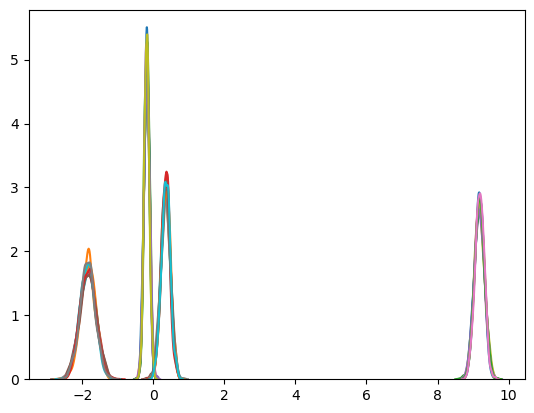

In [7]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

x_a = np.linspace(8.5, 10, 1000)
x_bA = np.linspace(-2.8, -1, 1000)
x_bR = np.linspace(-0.5, 0.15, 1000)
x_bAR = np.linspace(-0.25, 0.85, 1000)

HMC_POST_a = []
HMC_POST_bA = []
HMC_POST_bR = []
HMC_POST_bAR = []

k = 0

for _ in range(10):

    mcmc.run(is_cont_africa, ruggedness, log_gdp)

    samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
    
    x, y = sns.distplot(samples["a"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    HMC_POST_a.append(f(x_a))
    k += 1
    
    x, y = sns.distplot(samples["bA"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    HMC_POST_bA.append(f(x_bA))
    k += 1
    
    x, y = sns.distplot(samples["bR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    HMC_POST_bR.append(f(x_bR))
    k += 1
    
    x, y = sns.distplot(samples["bAR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    HMC_POST_bAR.append(f(x_bAR))
    k += 1

hmc_a_mean = np.mean(HMC_POST_a, axis=0)
hmc_bA_mean = np.mean(HMC_POST_bA, axis=0)
hmc_bR_mean = np.mean(HMC_POST_bR, axis=0)
hmc_bAR_mean = np.mean(HMC_POST_bAR, axis=0)
hmc_a_std = np.std(HMC_POST_a, axis=0)
hmc_bA_std = np.std(HMC_POST_bA, axis=0)
hmc_bR_std = np.std(HMC_POST_bR, axis=0)
hmc_bAR_std = np.std(HMC_POST_bAR, axis=0)

### KL divergence

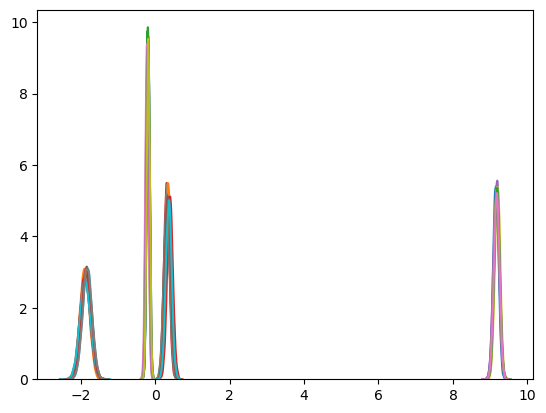

In [8]:
svi = SVI(model, guide, optim.Adam({"lr": .02}), loss=Trace_ELBO())

num_iters = 5000
num_samples = 10000

x_a = np.linspace(8.5, 10, 1000)
x_bA = np.linspace(-2.8, -1, 1000)
x_bR = np.linspace(-0.5, 0.15, 1000)
x_bAR = np.linspace(-0.25, 0.85, 1000)

SVI_KL_POST_a = []
SVI_KL_POST_bA = []
SVI_KL_POST_bR = []
SVI_KL_POST_bAR = []
SVI_KL_TIME = []

k = 0

for _ in range(10):

    pyro.clear_param_store()
    
    start_time = time.time()
    
    for i in range(num_iters):
        svi.step(is_cont_africa, ruggedness, log_gdp)
            
    SVI_KL_TIME.append(time.time() - start_time)
            
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}
    
    x, y = sns.distplot(samples["a"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_KL_POST_a.append(f(x_a))
    k += 1
    
    x, y = sns.distplot(samples["bA"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_KL_POST_bA.append(f(x_bA))
    k += 1
    
    x, y = sns.distplot(samples["bR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_KL_POST_bR.append(f(x_bR))
    k += 1
    
    x, y = sns.distplot(samples["bAR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_KL_POST_bAR.append(f(x_bAR))
    k += 1
    
kl_a_mean = np.mean(SVI_KL_POST_a, axis=0)
kl_bA_mean = np.mean(SVI_KL_POST_bA, axis=0)
kl_bR_mean = np.mean(SVI_KL_POST_bR, axis=0)
kl_bAR_mean = np.mean(SVI_KL_POST_bAR, axis=0)
kl_a_std = np.std(SVI_KL_POST_a, axis=0)
kl_bA_std = np.std(SVI_KL_POST_bA, axis=0)
kl_bR_std = np.std(SVI_KL_POST_bR, axis=0)
kl_bAR_std = np.std(SVI_KL_POST_bAR, axis=0)

### Alpha devergence, alpha = 0

Guessed max_plate_nesting = 2


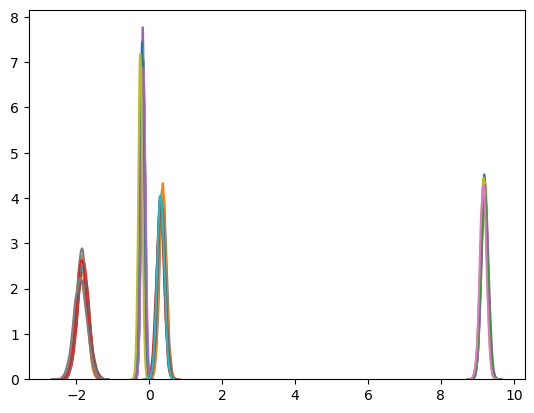

In [9]:
svi = SVI(model, guide, optim.Adam({"lr": .02}), loss=TraceRenyi_ELBO(alpha=0))

num_iters = 5000
num_samples = 10000

x_a = np.linspace(8.5, 10, 1000)
x_bA = np.linspace(-2.8, -1, 1000)
x_bR = np.linspace(-0.5, 0.15, 1000)
x_bAR = np.linspace(-0.25, 0.85, 1000)

SVI_Renyi_POST_a = []
SVI_Renyi_POST_bA = []
SVI_Renyi_POST_bR = []
SVI_Renyi_POST_bAR = []
SVI_Renyi_TIME = []

k = 0

for _ in range(10):

    pyro.clear_param_store()
    
    start_time = time.time()
    
    for i in range(num_iters):
        svi.step(is_cont_africa, ruggedness, log_gdp)
            
    SVI_Renyi_TIME.append(time.time() - start_time)
            
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}
    
    x, y = sns.distplot(samples["a"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Renyi_POST_a.append(f(x_a))
    k += 1
    
    x, y = sns.distplot(samples["bA"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Renyi_POST_bA.append(f(x_bA))
    k += 1
    
    x, y = sns.distplot(samples["bR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Renyi_POST_bR.append(f(x_bR))
    k += 1
    
    x, y = sns.distplot(samples["bAR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Renyi_POST_bAR.append(f(x_bAR))
    k += 1
    
renyi_a_mean = np.mean(SVI_Renyi_POST_a, axis=0)
renyi_bA_mean = np.mean(SVI_Renyi_POST_bA, axis=0)
renyi_bR_mean = np.mean(SVI_Renyi_POST_bR, axis=0)
renyi_bAR_mean = np.mean(SVI_Renyi_POST_bAR, axis=0)
renyi_a_std = np.std(SVI_Renyi_POST_a, axis=0)
renyi_bA_std = np.std(SVI_Renyi_POST_bA, axis=0)
renyi_bR_std = np.std(SVI_Renyi_POST_bR, axis=0)
renyi_bAR_std = np.std(SVI_Renyi_POST_bAR, axis=0)

### Alpha divergence, alpha = -100

Guessed max_plate_nesting = 2


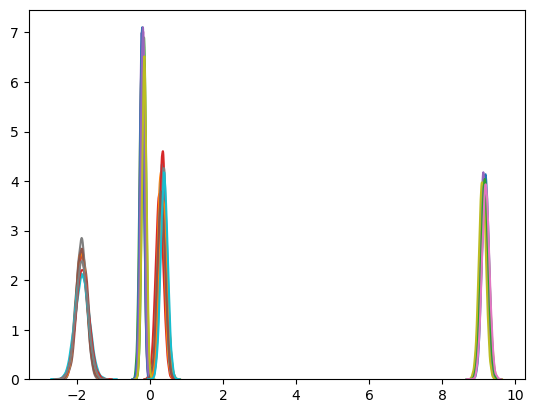

In [10]:
svi = SVI(model, guide, optim.Adam({"lr": .02}), loss=TraceRenyi_ELBO(alpha=-100))

num_iters = 5000
num_samples = 10000

x_a = np.linspace(8.5, 10, 1000)
x_bA = np.linspace(-2.8, -1, 1000)
x_bR = np.linspace(-0.5, 0.15, 1000)
x_bAR = np.linspace(-0.25, 0.85, 1000)

SVI_Renyi2_POST_a = []
SVI_Renyi2_POST_bA = []
SVI_Renyi2_POST_bR = []
SVI_Renyi2_POST_bAR = []

k = 0

for _ in range(10):

    pyro.clear_param_store()
    
    for i in range(num_iters):
        svi.step(is_cont_africa, ruggedness, log_gdp)
            
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}
    
    x, y = sns.distplot(samples["a"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Renyi2_POST_a.append(f(x_a))
    k += 1
    
    x, y = sns.distplot(samples["bA"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Renyi2_POST_bA.append(f(x_bA))
    k += 1
    
    x, y = sns.distplot(samples["bR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Renyi2_POST_bR.append(f(x_bR))
    k += 1
    
    x, y = sns.distplot(samples["bAR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Renyi2_POST_bAR.append(f(x_bAR))
    k += 1
    
renyi2_a_mean = np.mean(SVI_Renyi2_POST_a, axis=0)
renyi2_bA_mean = np.mean(SVI_Renyi2_POST_bA, axis=0)
renyi2_bR_mean = np.mean(SVI_Renyi2_POST_bR, axis=0)
renyi2_bAR_mean = np.mean(SVI_Renyi2_POST_bAR, axis=0)
renyi2_a_std = np.std(SVI_Renyi2_POST_a, axis=0)
renyi2_bA_std = np.std(SVI_Renyi2_POST_bA, axis=0)
renyi2_bR_std = np.std(SVI_Renyi2_POST_bR, axis=0)
renyi2_bAR_std = np.std(SVI_Renyi2_POST_bAR, axis=0)

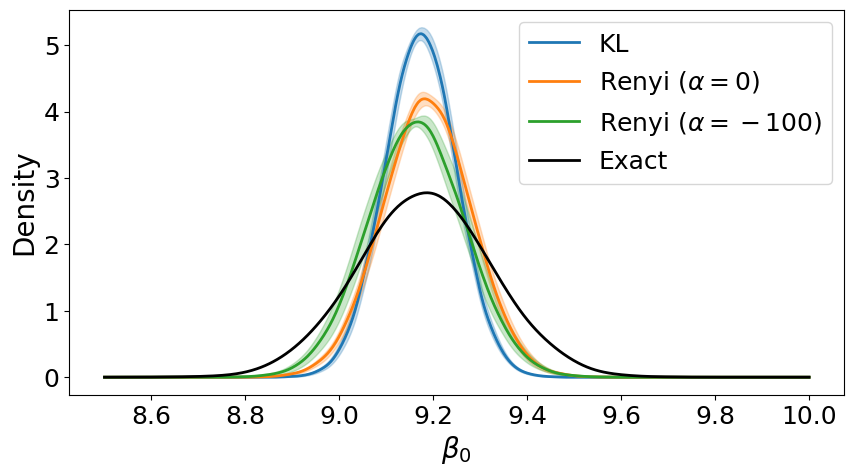

In [11]:
plt.figure(figsize=(10,5))
plt.plot(x_a, kl_a_mean, color="tab:blue", linewidth=2, label="KL")
plt.fill_between(x_a, kl_a_mean-.5*kl_a_std, kl_a_mean+.5*kl_a_std, alpha=.25, color="tab:blue")
plt.plot(x_a, renyi_a_mean, color="tab:orange", linewidth=2, label=r"Renyi ($\alpha=0$)")
plt.fill_between(x_a, renyi_a_mean-.5*renyi_a_std, renyi_a_mean+.5*renyi_a_std, alpha=.25, color="tab:orange")
plt.plot(x_a, renyi2_a_mean, color="tab:green", linewidth=2, label=r"Renyi ($\alpha=-100$)")
plt.fill_between(x_a, renyi2_a_mean-.5*renyi2_a_std, renyi2_a_mean+.5*renyi2_a_std, alpha=.25, color="tab:green")
plt.plot(x_a, hmc_a_mean, color="k", linewidth=2, label="Exact")
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel("Density", size=20)
plt.xlabel(r"$\beta_0$", size=20)
plt.savefig("beta0.pdf", bbox_inches='tight', format='pdf', dpi=400)

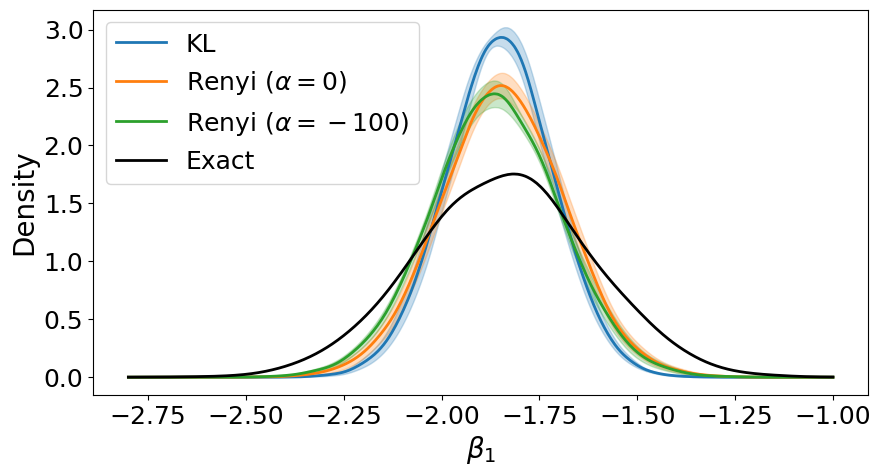

In [12]:
plt.figure(figsize=(10,5))
plt.plot(x_bA, kl_bA_mean, color="tab:blue", linewidth=2, label="KL")
plt.fill_between(x_bA, kl_bA_mean-.5*kl_bA_std, kl_bA_mean+.5*kl_bA_std, alpha=.25, color="tab:blue")
plt.plot(x_bA, renyi_bA_mean, color="tab:orange", linewidth=2, label=r"Renyi ($\alpha=0$)")
plt.fill_between(x_bA, renyi_bA_mean-.5*renyi_bA_std, renyi_bA_mean+.5*renyi_bA_std, alpha=.25, color="tab:orange")
plt.plot(x_bA, renyi2_bA_mean, color="tab:green", linewidth=2, label=r"Renyi ($\alpha=-100$)")
plt.fill_between(x_bA, renyi2_bA_mean-.5*renyi2_bA_std, renyi2_bA_mean+.5*renyi2_bA_std, alpha=.25, color="tab:green")
plt.plot(x_bA, hmc_bA_mean, color="k", linewidth=2, label="Exact")
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel("Density", size=20)
plt.xlabel(r"$\beta_1$", size=20)
plt.savefig("beta1.pdf", bbox_inches='tight', format='pdf', dpi=400)

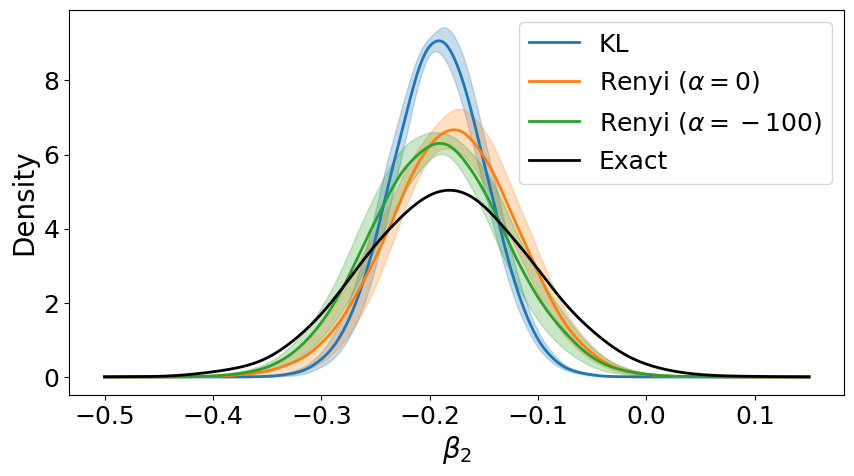

In [13]:
plt.figure(figsize=(10,5))
plt.plot(x_bR, kl_bR_mean, color="tab:blue", linewidth=2, label="KL")
plt.fill_between(x_bR, kl_bR_mean-.5*kl_bR_std, kl_bR_mean+.5*kl_bR_std, alpha=.25, color="tab:blue")
plt.plot(x_bR, renyi_bR_mean, color="tab:orange", linewidth=2, label=r"Renyi ($\alpha=0$)")
plt.fill_between(x_bR, renyi_bR_mean-.5*renyi_bR_std, renyi_bR_mean+.5*renyi_bR_std, alpha=.25, color="tab:orange")
plt.plot(x_bR, renyi2_bR_mean, color="tab:green", linewidth=2, label=r"Renyi ($\alpha=-100$)")
plt.fill_between(x_bR, renyi2_bR_mean-.5*renyi2_bR_std, renyi2_bR_mean+.5*renyi2_bR_std, alpha=.25, color="tab:green")
plt.plot(x_bR, hmc_bR_mean, color="k", linewidth=2, label="Exact")
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel("Density", size=20)
plt.xlabel(r"$\beta_2$", size=20)
plt.savefig("beta2.pdf", bbox_inches='tight', format='pdf', dpi=400)

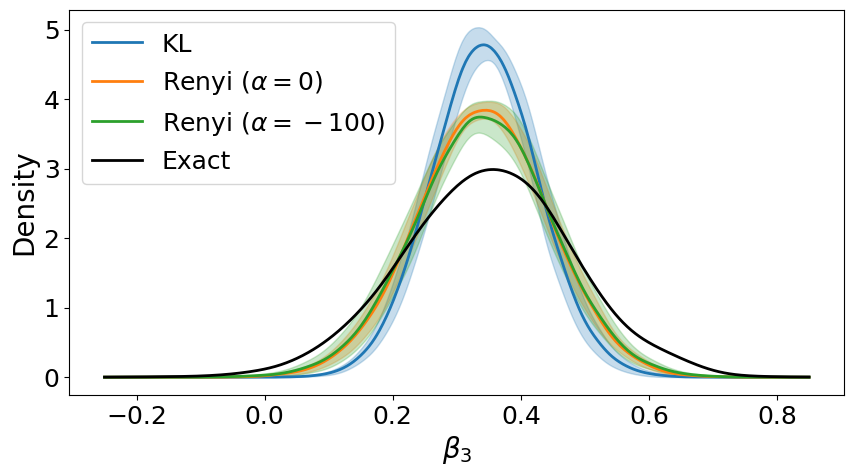

In [14]:
plt.figure(figsize=(10,5))
plt.plot(x_bAR, kl_bAR_mean, color="tab:blue", linewidth=2, label="KL")
plt.fill_between(x_bAR, kl_bAR_mean-.5*kl_bAR_std, kl_bAR_mean+.5*kl_bAR_std, alpha=.25, color="tab:blue")
plt.plot(x_bAR, renyi_bAR_mean, color="tab:orange", linewidth=2, label=r"Renyi ($\alpha=0$)")
plt.fill_between(x_bAR, renyi_bAR_mean-.5*renyi_bAR_std, renyi_bAR_mean+.5*renyi_bAR_std, alpha=.25, color="tab:orange")
plt.plot(x_bAR, renyi2_bAR_mean, color="tab:green", linewidth=2, label=r"Renyi ($\alpha=-100$)")
plt.fill_between(x_bAR, renyi2_bAR_mean-.5*renyi2_bAR_std, renyi2_bAR_mean+.5*renyi2_bAR_std, alpha=.25, color="tab:green")
plt.plot(x_bAR, hmc_bAR_mean, color="k", linewidth=2, label="Exact")
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel("Density", size=20)
plt.xlabel(r"$\beta_3$", size=20)
plt.savefig("beta3.pdf", bbox_inches='tight', format='pdf', dpi=400)

### Tail-adaptive $f$-divergence

In [15]:
svi = SVI(model, guide, optim.Adam({"lr": .02}), loss=TraceTailAdaptive_ELBO(num_particles=10, vectorize_particles=True))

num_iters = 5000
num_samples = 10000

x_a = np.linspace(8.5, 10, 1000)
x_bA = np.linspace(-2.8, -1, 1000)
x_bR = np.linspace(-0.5, 0.15, 1000)
x_bAR = np.linspace(-0.25, 0.85, 1000)

SVI_Tail_POST_a = []
SVI_Tail_POST_bA = []
SVI_Tail_POST_bR = []
SVI_Tail_POST_bAR = []
SVI_Tail_TIME = []

k = 0

for _ in range(10):

    pyro.clear_param_store()
    
    start_time = time.time()
    
    for i in range(num_iters):
        elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
        
    SVI_Tail_TIME.append(time.time() - start_time)
            
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}
    
    x, y = sns.distplot(samples["a"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Tail_POST_a.append(f(x_a))
    k += 1
    
    x, y = sns.distplot(samples["bA"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Tail_POST_bA.append(f(x_bA))
    k += 1
    
    x, y = sns.distplot(samples["bR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Tail_POST_bR.append(f(x_bR))
    k += 1
    
    x, y = sns.distplot(samples["bAR"], hist=False).get_lines()[k].get_data()
    f = interpolate.interp1d(x, y, bounds_error=False, fill_value=(y[0],y[-1]))
    SVI_Tail_POST_bAR.append(f(x_bAR))
    k += 1
    
tail_a_mean = np.mean(SVI_Tail_POST_a, axis=0)
tail_bA_mean = np.mean(SVI_Tail_POST_bA, axis=0)
tail_bR_mean = np.mean(SVI_Tail_POST_bR, axis=0)
tail_bAR_mean = np.mean(SVI_Tail_POST_bAR, axis=0)
tail_a_std = np.std(SVI_Tail_POST_a, axis=0)
tail_bA_std = np.std(SVI_Tail_POST_bA, axis=0)
tail_bR_std = np.std(SVI_Tail_POST_bR, axis=0)
tail_bAR_std = np.std(SVI_Tail_POST_bAR, axis=0)

Guessed max_plate_nesting = 2


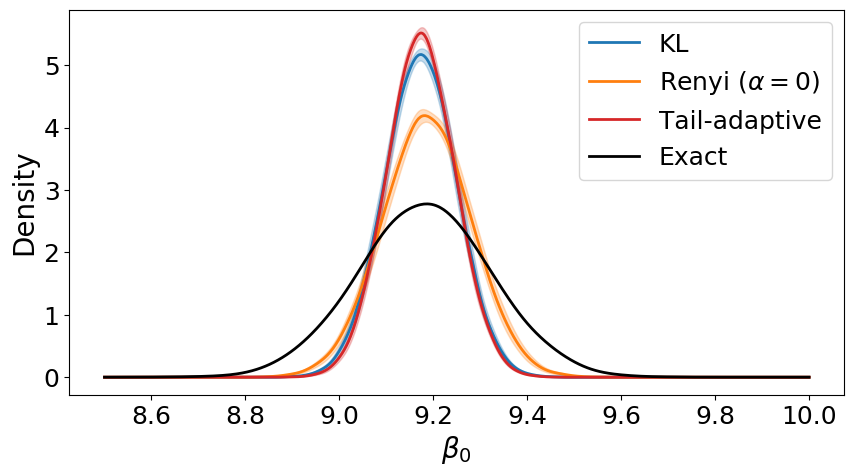

In [16]:
plt.figure(figsize=(10,5))
plt.plot(x_a, kl_a_mean, color="tab:blue", linewidth=2, label="KL")
plt.fill_between(x_a, kl_a_mean-.5*kl_a_std, kl_a_mean+.5*kl_a_std, alpha=.25, color="tab:blue")
plt.plot(x_a, renyi_a_mean, color="tab:orange", linewidth=2, label=r"Renyi ($\alpha=0$)")
plt.fill_between(x_a, renyi_a_mean-.5*renyi_a_std, renyi_a_mean+.5*renyi_a_std, alpha=.25, color="tab:orange")
plt.plot(x_a, tail_a_mean, color="tab:red", linewidth=2, label="Tail-adaptive")
plt.fill_between(x_a, tail_a_mean-.5*tail_a_std, tail_a_mean+.5*tail_a_std, alpha=.25, color="tab:red")
plt.plot(x_a, hmc_a_mean, color="k", linewidth=2, label="Exact")
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel("Density", size=20)
plt.xlabel(r"$\beta_0$", size=20)
plt.savefig("beta0_tail.pdf", bbox_inches='tight', format='pdf', dpi=400)

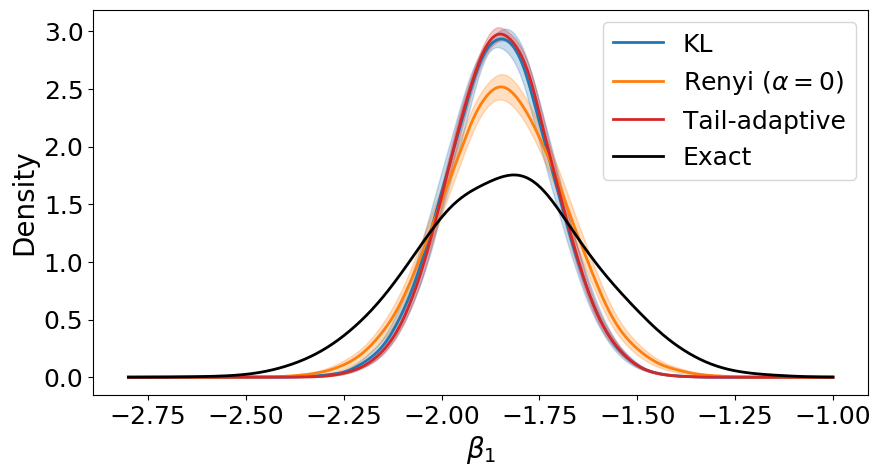

In [17]:
plt.figure(figsize=(10,5))
plt.plot(x_bA, kl_bA_mean, color="tab:blue", linewidth=2, label="KL")
plt.fill_between(x_bA, kl_bA_mean-.5*kl_bA_std, kl_bA_mean+.5*kl_bA_std, alpha=.25, color="tab:blue")
plt.plot(x_bA, renyi_bA_mean, color="tab:orange", linewidth=2, label=r"Renyi ($\alpha=0$)")
plt.fill_between(x_bA, renyi_bA_mean-.5*renyi_bA_std, renyi_bA_mean+.5*renyi_bA_std, alpha=.25, color="tab:orange")
plt.plot(x_bA, tail_bA_mean, color="tab:red", linewidth=2, label="Tail-adaptive")
plt.fill_between(x_bA, tail_bA_mean-.5*tail_bA_std, tail_bA_mean+.5*tail_bA_std, alpha=.25, color="tab:red")
plt.plot(x_bA, hmc_bA_mean, color="k", linewidth=2, label="Exact")
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel("Density", size=20)
plt.xlabel(r"$\beta_1$", size=20)
plt.savefig("beta1_tail.pdf", bbox_inches='tight', format='pdf', dpi=400)

In [18]:
plt.figure(figsize=(10,5))
plt.plot(x_bR, kl_bR_mean, color="tab:blue", linewidth=2, label="KL")
plt.fill_between(x_bR, kl_bR_mean-.5*kl_bR_std, kl_bR_mean+.5*kl_bR_std, alpha=.25, color="tab:blue")
plt.plot(x_bR, renyi_bR_mean, color="tab:orange", linewidth=2, label=r"Renyi ($\alpha=0$)")
plt.fill_between(x_bR, renyi_bR_mean-.5*renyi_bR_std, renyi_bR_mean+.5*renyi_bR_std, alpha=.25, color="tab:orange")
plt.plot(x_bR, tail_bR_mean, color="tab:red", linewidth=2, label="Tail-adaptive")
plt.fill_between(x_bR, tail_bR_mean-.5*tail_bR_std, tail_bR_mean+.5*tail_bR_std, alpha=.25, color="tab:red")
plt.plot(x_bR, hmc_bR_mean, color="k", linewidth=2, label="Exact")
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel("Density", size=20)
plt.xlabel(r"$\beta_2$", size=20)
plt.savefig("beta2_tail.pdf", bbox_inches='tight', format='pdf', dpi=400)

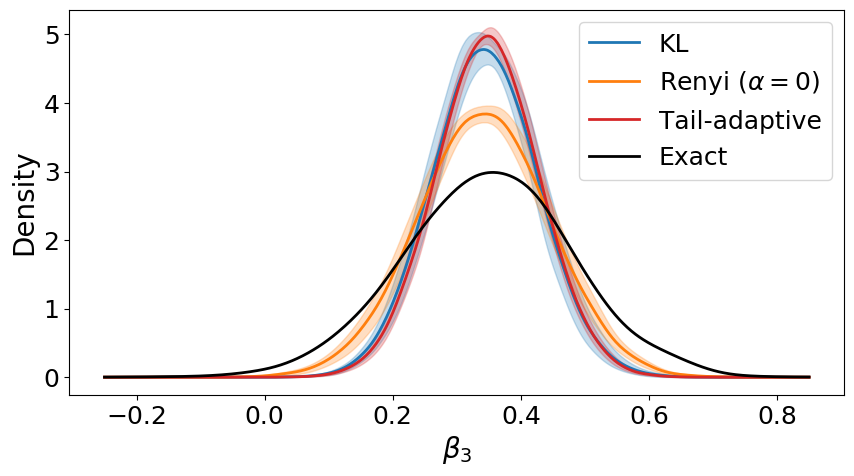

In [19]:
plt.figure(figsize=(10,5))
plt.plot(x_bAR, kl_bAR_mean, color="tab:blue", linewidth=2, label="KL")
plt.fill_between(x_bAR, kl_bAR_mean-.5*kl_bAR_std, kl_bAR_mean+.5*kl_bAR_std, alpha=.25, color="tab:blue")
plt.plot(x_bAR, renyi_bAR_mean, color="tab:orange", linewidth=2, label=r"Renyi ($\alpha=0$)")
plt.fill_between(x_bAR, renyi_bAR_mean-.5*renyi_bAR_std, renyi_bAR_mean+.5*renyi_bAR_std, alpha=.25, color="tab:orange")
plt.plot(x_bAR, tail_bAR_mean, color="tab:red", linewidth=2, label="Tail-adaptive")
plt.fill_between(x_bAR, tail_bAR_mean-.5*tail_bAR_std, tail_bAR_mean+.5*tail_bAR_std, alpha=.25, color="tab:red")
plt.plot(x_bAR, hmc_bAR_mean, color="k", linewidth=2, label="Exact")
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel("Density", size=20)
plt.xlabel(r"$\beta_3$", size=20)
plt.savefig("beta3_tail.pdf", bbox_inches='tight', format='pdf', dpi=400)

### Pyro's alpha divergence

In [20]:
from pyro.infer import RenyiELBO

svi = SVI(model, guide, optim.Adam({"lr": .02}), loss=RenyiELBO(alpha=0))

num_iters = 5000

SVI_PyroRenyi_TIME = []

k = 0

for _ in range(10):

    pyro.clear_param_store()
    
    start_time = time.time()
    
    for i in range(num_iters):
        svi.step(is_cont_africa, ruggedness, log_gdp)
            
    SVI_PyroRenyi_TIME.append(time.time() - start_time)

### Computation times

In [21]:
np.mean(SVI_KL_TIME)

17.68641016483307

In [22]:
np.mean(SVI_Renyi_TIME)

21.33032269477844

In [23]:
np.mean(SVI_PyroRenyi_TIME)

33.72600862979889

In [24]:
np.mean(SVI_Tail_TIME)

21.427649903297425